# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
    #transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # is normalization necessary? Is this the best way?
    ])

valid_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # is normalization necessary? Is this the best way?
    ])

train_data = datasets.ImageFolder("/data/landmark_images/train", transform=train_transform)
valid_data = datasets.ImageFolder("/data/landmark_images/train", transform=valid_test_transform)
test_data = datasets.ImageFolder("/data/landmark_images/test", transform=valid_test_transform)

classes = train_data.classes

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)


loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- I chose 224 for image size because it's the input size of the vgg model use in transfer learning and that way I can do the same preprocessing for the model from scratch and the transfer learning model. 
- Then I center-cropped the images because that seemed easiest.
- In the training dataset I augmented the training dataset by applying the random horizontal flip transformation.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

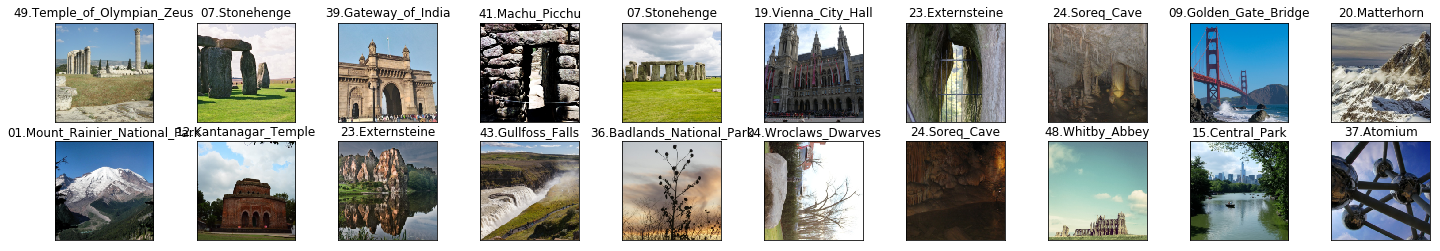

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
import torch.optim as optim
from torch import nn

In [6]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.Adam(model.parameters(), lr=0.0001)  # not sure about this learning rate

In [23]:
print(classes)

['00.Haleakala_National_Park', '01.Mount_Rainier_National_Park', '02.Ljubljana_Castle', '03.Dead_Sea', '04.Wroclaws_Dwarves', '05.London_Olympic_Stadium', '06.Niagara_Falls', '07.Stonehenge', '08.Grand_Canyon', '09.Golden_Gate_Bridge', '10.Edinburgh_Castle', '11.Mount_Rushmore_National_Memorial', '12.Kantanagar_Temple', '13.Yellowstone_National_Park', '14.Terminal_Tower', '15.Central_Park', '16.Eiffel_Tower', '17.Changdeokgung', '18.Delicate_Arch', '19.Vienna_City_Hall', '20.Matterhorn', '21.Taj_Mahal', '22.Moscow_Raceway', '23.Externsteine', '24.Soreq_Cave', '25.Banff_National_Park', '26.Pont_du_Gard', '27.Seattle_Japanese_Garden', '28.Sydney_Harbour_Bridge', '29.Petronas_Towers', '30.Brooklyn_Bridge', '31.Washington_Monument', '32.Hanging_Temple', '33.Sydney_Opera_House', '34.Great_Barrier_Reef', '35.Monumento_a_la_Revolucion', '36.Badlands_National_Park', '37.Atomium', '38.Forth_Bridge', '39.Gateway_of_India', '40.Stockholm_City_Hall', '41.Machu_Picchu', '42.Death_Valley_National_Pa

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 3 input channels because of RGB
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
#         self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        # pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layers
        self.fc1 = nn.Linear(64*28*28, 500)
        self.bn4 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, len(classes))
        # dropout layer
        self.dropout = nn.Dropout(0.25)
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = self.pool(F.relu(self.conv4(x)))
#         x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 64*28*28)
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
    
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
- Initially I tried to create a network similar to those in the lessons, which include a series of three convolutional + max pooling layers, which increased the number of convolutions in each layer while decreasing the x*y size of the inputs through pooling at each layer. This was followed by a few linear layers with dropout. However, this strategy was not working very well, even when I changed the optimizer to Adam and decreased the learning rate. The loss did not decrease very much and in fact often started to increase or stabilize around 4. And the test accuracy was ~2% -- only as good as chance.
- Next I tried to increas the number of convolutional + max pooling layers to see if this helped performance. It did not help.
- After reading the help articles, I saw some mentor suggestions for including batch normalization layers. I included batch normalization after every convolutional layer and also after the first linear layer. This improved training so that loss decreased below 3 and accuracy around 30%.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
    

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss
            outputs = model(data)
            loss = criterion(outputs, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            print("Saving model with loss:", valid_loss)
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)

              
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [62]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        # m.bias.data.fill_(0)
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.633548 	Validation Loss: 3.752516
Saving model with loss: 3.7525157451629636
Epoch: 2 	Training Loss: 3.265692 	Validation Loss: 3.240221
Saving model with loss: 3.240220875740051
Epoch: 3 	Training Loss: 3.033976 	Validation Loss: 3.068605
Saving model with loss: 3.068604836463928
Epoch: 4 	Training Loss: 2.871454 	Validation Loss: 2.938858
Saving model with loss: 2.9388581991195677
Epoch: 5 	Training Loss: 2.711055 	Validation Loss: 2.955073
Epoch: 6 	Training Loss: 2.538152 	Validation Loss: 2.957494
Epoch: 7 	Training Loss: 2.406211 	Validation Loss: 2.878995
Saving model with loss: 2.8789950489997866
Epoch: 8 	Training Loss: 2.271108 	Validation Loss: 2.862174
Saving model with loss: 2.8621739912033086
Epoch: 9 	Training Loss: 2.101047 	Validation Loss: 2.949003
Epoch: 10 	Training Loss: 1.996519 	Validation Loss: 2.879793
Epoch: 11 	Training Loss: 1.810567 	Validation Loss: 2.939554
Epoch: 12 	Training Loss: 1.659625 	Validation Loss: 3.023950
Epoch: 13

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [63]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 10

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.663417 	Validation Loss: 3.462244
Saving model with loss: 3.462243995666503
Epoch: 2 	Training Loss: 3.281910 	Validation Loss: 3.147980
Saving model with loss: 3.1479801607131956
Epoch: 3 	Training Loss: 3.048121 	Validation Loss: 3.035434
Saving model with loss: 3.035434494018555
Epoch: 4 	Training Loss: 2.819524 	Validation Loss: 2.964401
Saving model with loss: 2.964400806427002
Epoch: 5 	Training Loss: 2.595410 	Validation Loss: 2.907206
Saving model with loss: 2.9072064781188964
Epoch: 6 	Training Loss: 2.451013 	Validation Loss: 2.929642
Epoch: 7 	Training Loss: 2.262808 	Validation Loss: 2.931969
Epoch: 8 	Training Loss: 2.011371 	Validation Loss: 2.941355
Epoch: 9 	Training Loss: 1.784394 	Validation Loss: 3.056717
Epoch: 10 	Training Loss: 1.589892 	Validation Loss: 3.091618


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [65]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.849449


Test Accuracy: 29% (369/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [11]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [24]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.classifier.parameters(), lr=0.0001)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [25]:
## TODO: Specify model architecture
from torchvision import models

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

model_transfer.classifier[0] = nn.Linear(25088, 4096, bias=True)
model_transfer.classifier[3] = nn.Linear(4096, 4096, bias=True)
model_transfer.classifier[6] = nn.Linear(4096, len(classes), bias=True)

optimizer_transfer = get_optimizer_transfer(model_transfer)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
- Initially, I froze all of the layers of the vgg model and only replaced the last layer of the network with a new layer that output the number of classes for the landmark problem (50). This is similar to the approach in the Transfer Learning lesson with Cezanne. However, this led to poor results: the training and validation loss were nan.
- I went to the help section to see what the mentors suggested and saw that it is better to update all the linear classification layers when fine tuning the model. This reminded me of the module in the Transfer learning section that discussed different scenarios for transfer learning - large vs. small datasets and similar vs. different training objectives. So, it seems that the training objectives here are different enough to require needing to update more layers in the fine tuning step.
- When I changed the model to train and update all the linear layers, the performance was much better with a validation loss under 2 and test accuracy greater than 60% after 5 epochs of training.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [26]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
n_epochs = 5
valid_loss_min = np.Inf

for epoch in range(n_epochs):
    
    train_loss = 0
    valid_loss = 0
    model_transfer.train()  # put the model in "training" mode
    
    for batch_idx, (data, target) in enumerate(loaders_transfer['train']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        outputs = model_transfer(data)
        loss = criterion_transfer(outputs, target)
        loss.backward()
        optimizer_transfer.step()
        train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(loaders_transfer['valid']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        outputs = model_transfer(data)
        loss = criterion_transfer(outputs, target)
        valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        valid_loss
        ))

    ## if the validation loss has decreased, save the model at 'model_transfer.pt'
    if valid_loss < valid_loss_min:
        print("Saving model with loss:", valid_loss)
        valid_loss_min = valid_loss
        torch.save(model_transfer.state_dict(), 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 0 	Training Loss: 3.677102 	Validation Loss: 3.004457
Saving model with loss: 3.00445677280426
Epoch: 1 	Training Loss: 2.358674 	Validation Loss: 2.407743
Saving model with loss: 2.4077429628372196
Epoch: 2 	Training Loss: 2.062324 	Validation Loss: 1.757084
Saving model with loss: 1.7570842278003689
Epoch: 3 	Training Loss: 1.359634 	Validation Loss: 1.559023
Saving model with loss: 1.5590227466821673
Epoch: 4 	Training Loss: 0.915700 	Validation Loss: 1.671438


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [27]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.439359


Test Accuracy: 65% (815/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [78]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    # encode the image so that it can be input into model
    image = Image.open(img_path).convert('RGB')
    # transform image to be appropriate size for model
    image = valid_test_transform(image)
    # unsqueeze image so that it has the correct number of dimensions for the model
    image = torch.unsqueeze(image, 0)
    # run image through model and get output - what does output look like?
    # transfer image to GPUs
    image = image.cuda()
    output = model_transfer(image)
    # extract top k class predictions from output
    predictions = torch.topk(output, k)
    # map the output indices to the class names
    predictions_list = list(np.array(classes)[predictions[1][0]])
    return [landmark[3:].replace("_", " ") for landmark in predictions_list]

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Brooklyn Bridge',
 'Dead Sea',
 'Eiffel Tower']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)


Is this picture of
Golden Gate Bridge,
Forth Bridge,
or Brooklyn Bridge?


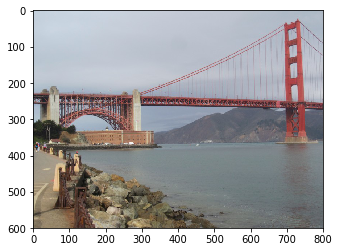

In [79]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)
    
    print("")
    print("Is this picture of")
    for idx in range(len(predicted_landmarks)-1):
        print(predicted_landmarks[idx] + ",")
    print("or " + predicted_landmarks[idx+1] + "?")
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

It performed worse than I expected! I uploaded 5 photos I've personally taken from landmarks included in the classifer: 2 from Machu Picchu, 2 from Taj Mahal, and 1 from Mt. Rainier. The classifier only identified one of the images correctly and it was not what I expected -- it correctly classified one of the Machu Picchu photos and not the Taj Mahal photos, which seemed easier/more obvious to me.

- Additional training data for the landmarks / locations would help. 
- More transforms could be applied at the data preprocessing stage. This could improve the model's ability to accurately classify landmarks because it has seen them in additional contexts.
- Perhaps some of the convolutional layers could be updated during training, not just the linear layers. Alternatively, the later convolutional layers could be removed and new linear layers trained on top of those.
- It might also help to train the current architecture for more than 5 epochs.

In [72]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

# load images where they can be accessed here

# my own pictures of Mt. Rainier, Machu Picchu, and Taj Mahal
img_paths = ['images/my_images/IMG_0805.jpeg', 'images/my_images/IMG_0827.jpeg', \
             'images/my_images/rainier-2019.jpg', 'images/my_images/IMG_2232.jpeg', \
             'images/my_images/IMG_2233.jpeg']


Is this picture of
Haleakala National Park,
Grand Canyon,
or Matterhorn?


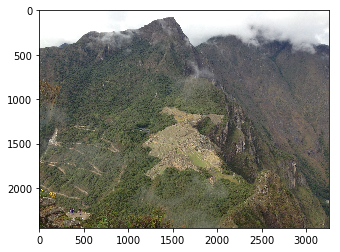

In [80]:
suggest_locations(img_paths[0])


Is this picture of
Machu Picchu,
Haleakala National Park,
or Matterhorn?


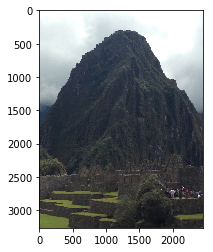

In [81]:
suggest_locations(img_paths[1])


Is this picture of
Matterhorn,
Banff National Park,
or Haleakala National Park?


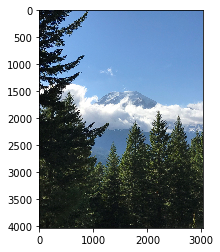

In [82]:
suggest_locations(img_paths[2])


Is this picture of
Petronas Towers,
Gateway of India,
or Stockholm City Hall?


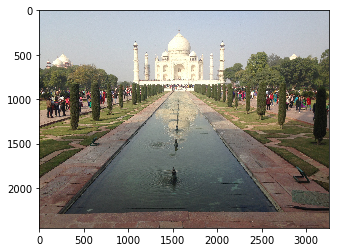

In [83]:
suggest_locations(img_paths[3])


Is this picture of
Gateway of India,
Stockholm City Hall,
or Monumento a la Revolucion?


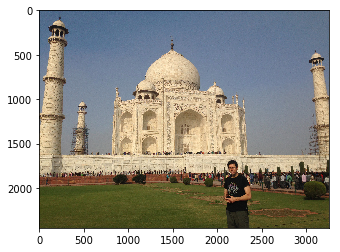

In [84]:
suggest_locations(img_paths[4])